# Julia の紹介<br><small>機械学習のための Julia</small>

<p style="text-align:center;font-size:150%;line-height:150%">2015/11/28 機械学習 名古屋 第2回勉強会<br>後藤 俊介 ( @antimon2 )</p>

## 自己紹介

+ 名前：後藤 俊介
+ 所属：株式会社コスモルート クラウドR&Dグループ 数学班
+ 言語：Ruby, JavaScript, Python, **Julia**, Haxe, …
+ twitter: [@antimon2](https://twitter.com/antimon2 "あんちもん2(@antimon2)さん | Twitter")
+ Facebook: [antimon2](https://www.facebook.com/antimon2 "後藤 俊介")
+ GitHub: [antimon2](https://github.com/antimon2/ "antimon2 (GOTOH Shunsuke)")

↑今日はこの **Julia** の話。

## Julia とは？

- [The Julia Language](http://julialang.org/)
- 2015/10/04 に [v0.4.0 がリリース](http://julialang.org/blog/2015/10/julia-0.4-release/)（2015/11/27 現在の最新は v0.4.1）
- Python/Ruby/R 等の「いいとこどり」言語（詳細後述）
- 動作が速い！（LLVM JIT コンパイル）

## Julia の特長

> + Rのように中身がぐちゃぐちゃでなく、
+ Rubyのように遅くなく、
+ Lispのように原始的またはエレファントでなく、
+ Prologのように変態的なところはなく、
+ Javaのように硬すぎることはなく、
+ Haskellのように抽象的すぎない
> 
> ほどよい言語である

引用：http://www.slideshare.net/Nikoriks/julia-28059489

Julia の目指すもの：

+ C のように高速だけど、  
  Ruby のような動的型付言語である
+ Lisp のように同じ文法で書けるマクロがあって、しかも  
  Matlab のような直感的な数式表現もできる
+ Python のように総合的なプログラミングができて、  
  R のように統計処理も得意で、  
  Perl のように文字列処理もできて、  
  Matlab のように線形代数もできて、  
  shell のように複数のプログラムを組み合わせることもできる
+ 超初心者にも習得は簡単で、  
  超上級者の満足にも応えられる
+ インタラクティブにも動作して、コンパイルもできる

（[Why We Created Julia](http://julialang.org/blog/2012/02/why-we-created-julia/) から抜粋・私訳）

## 機械学習への適用

自分で実装編。

※ コード例も兼ねて。  
※ この記事は Julia v0.4.1 を基準としています。

### 例1：単純な線形回帰

1変数（or 多くても10変数程度）、データ数100件程度  
⇒ 行列作ってバックスラッシュ演算子で高速に求解可能。

In [1]:
# 手作りサンプルデータ
x = rand(100) .* 100
y = randn(100) .* 5 .+ x .* 0.7 .+ 10

# 行列作成
X = [ones(100, 1) x;]

# パラメータ求解（Normal Equation 利用）
# θ = X \ y
θ = (X' * X) \ (X' * y);

※「`.*`」「`.+`」等は、配列（ベクトル、行列）の「要素ごとの積/和」。相手がスカラーなら「すべての要素への演算」になる。  
※配列（ベクトル、行列）の記法は、MATLAB/Octave 由来。  
※バックスラッシュ演算子 `\` も MATLAB/Octave 由来。  
※↑この「θ」のように unicode 文字を識別子として利用可能。

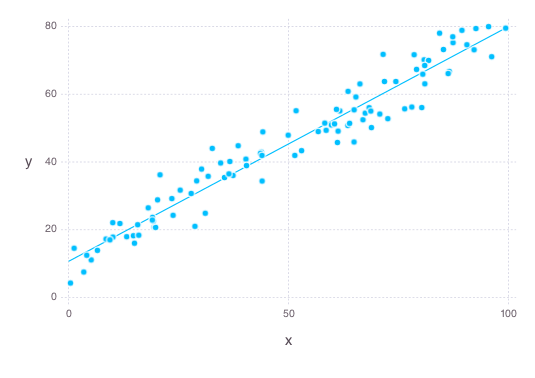

In [2]:
# 結果プロット
using Gadfly  # ← Julia 定番のデータプロットライブラリ

x_linspace = linspace(0,100)
f(x) = θ[1] .+ x .* θ[2]
plot(layer(x=x, y=y, Geom.point), layer(x=x_linspace, y=f(x_linspace), Geom.line))

※「`f(x) = 〜`」というのは、関数のインライン定義。簡単な関数なら、このような数式定義のような感じで関数定義できる。

### 例2：簡単な K-means

本日のハンズオンで利用したサンプルデータを利用。

In [3]:
# データ読込
data = open(readdlm, "./CodeIQ_data.txt", "r")

K=3
X=data;

※ `open()` 関数の第1引数に関数を渡すと、ファイルの内容をその関数で処理した結果を返す（処理が終わったら勝手に `close` してくれる）。  
※ `readdlm()` 関数は、デフォルトでは「各行ごとにホワイトスペースを区切子として分割して適切な型に変換した結果からなる行列を返す」という動き。（CSVファイルを読み込む場合は`readcsv()`関数を利用する）

In [4]:
# クラスタ重心初期化
function initCentroids(X, K)
    randidx = randperm(size(X, 1))
    X[randidx[1:K], :]
end

initCentroids (generic function with 1 method)

※行列（＝2次元配列）の要素の参照方法は、`A[x, y]`。`x`や`y`が配列（ベクトル）や `Range` ならば、対応するインデックスの要素を収集する（特殊な例として`:`と書くと「すべて」の意味）。

In [5]:
# チェック
initialCentroids = initCentroids(X, K)

3x2 Array{Float64,2}:
 16.62  16.67
  2.03   8.98
 11.3    2.63

In [6]:
# クラスタ割り付けステップ
function findClosestCentroids(X, centroids)
    K = size(centroids, 1)
    map(1:size(X, 1)) do i
        x = vec(X[i, :])
        ts = [x - vec(centroids[j,:]) for j=1:K]
        ls = [dot(t, t) for t=ts]
        indmin(ls)
    end
end

findClosestCentroids (generic function with 1 method)

※`vec()`関数は、配列（行列）をベクトル（＝1次元の配列）に変換する。`vec(A)`は`A[:]`と書いても同じ結果になる。  
※`[v for v=〜]` は、Julia のリスト内包表記。`in`ではなく`=`で記述出来る（これも MATLAB/Octave 由来）以外は Python のそれに類似（ただし条件節は記述できない）。

In [7]:
# チェック
idxs = findClosestCentroids(X, initialCentroids)

96-element Array{Int64,1}:
 3
 2
 1
 3
 3
 2
 3
 3
 2
 1
 2
 1
 2
 ⋮
 2
 2
 3
 2
 3
 3
 1
 2
 2
 3
 1
 2

In [8]:
# 重心移動ステップ
function computeCentroids(X, idxs, K)
    m, n = size(X)  # m 不使用
    centroids = zeros(K, n)
    for j = 1:K
        centroids[j, :] = mean(X[idxs .== j, :], 1) # ← idxs が j（=1,2,…,K）の行のみ抽出して、列ごとに平均値を算出
    end
    centroids
end


computeCentroids (generic function with 1 method)

※ `A .== n` も要素ごとの演算で、結果は「『Aの対応する要素が、nと値が等しければ`true`、そうでなければ`false`』となっている配列」となる。  
※ `X[list]` で`list`が`true`/`false`からなる配列の場合、「『`list`で`true`が格納されているインデックス』に対応する値を`X`から抽出した配列」を返す。

In [9]:
# チェック
computeCentroids(X, idxs, K)

3x2 Array{Float64,2}:
 14.2828   14.0707 
  3.91875  11.1456 
 10.158     3.10314

In [10]:
# ループ実施
function runKMeans(X, initialCentroids, max_iters=10)
    m, n = size(X)
    K = size(initialCentroids, 1)
    centroids = initialCentroids
    prev_centroids = centroids
    idxs = zeros(m, 1)
    
    for i = 1:max_iters
        idxs = findClosestCentroids(X, centroids)
        centroids = computeCentroids(X, idxs, K)
        if centroids == prev_centroids
            break
        end
        prev_centroids = centroids
    end
    
    return centroids, idxs
end

runKMeans (generic function with 2 methods)

※`size(X)`は、`X` の各軸のサイズからなる tuple（2次元（＝行列）の場合、(行数, 列数) ）を返す。
※`size(X, d)`と書くと、`X` のd番目の軸のサイズ（2次元（＝行列）の場合、1なら行数、2なら列数）を返す。

In [11]:
# 結果表示
function dispResult(X, idxs)
    plotdata = [X [string(i) for i=idxs];]
    plot(x=plotdata[:,1], y=plotdata[:,2], color=plotdata[:,3])
end

dispResult (generic function with 1 method)

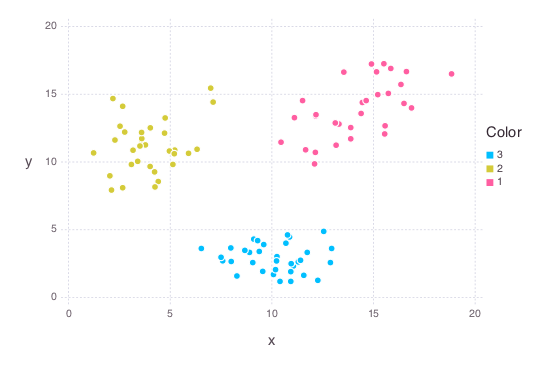

In [12]:
# 実行
initial_centroids = initCentroids(X, K)
centroids, idxs = runKMeans(X, initial_centroids)
dispResult(X, idxs)

※ その他、学習曲線プロット等も可能（省略）

## 機械学習への適用 その2

追加パッケージ利用編。

便利なライブラリは素直に利用しましょう。

### 機械学習ライブラリ（主なもの）

+ [MLBase](https://github.com/JuliaStats/MLBase.jl)（機械学習の基本アルゴリズムを集めたパッケージ。他↓のいくつかのライブラリで required されている）
+ [Regression.jl](https://github.com/lindahua/Regression.jl)（○○回帰（線形回帰、リッジ回帰、ロジスティック回帰等））
+ [LIBSVM](http://github.com/simonster/LIBSVM.jl)（SVMパッケージ。libsvm の Julia ラッパー）
+ [Clustering.jl](https://github.com/JuliaStats/Clustering.jl)（K-means その他クラスタリング）
+ [DecisionTree.jl](https://github.com/bensadeghi/DecisionTree.jl)（決定木、ランダムフォレスト）
+ [BackpropNeuralNet](https://github.com/compressed/BackpropNeuralNet.jl)（ニューラルネット）

### 例1：Regression.jl で 線形回帰

先ほど利用した手作りサンプルデータを利用

In [ ]:
# パッケージ読込
# Pkg.add("Regression")
using Regression
# ※ 2015/11/27 現在、大量の Warning が出力されます(>_<) ので出力隠しておきます

In [14]:
# 行列作成
X = [ones(100, 1) x;];

In [15]:
# 例1-1: linearreg + Regression.solve で求解
ret = Regression.solve(linearreg(X', y); options=Regression.Options(verbosity=:iter))

 Iter

RiskMinSolution:
- sol:       (2,) Array{Float64,1}
- fval:      1148.2793332367219
- niters:    8
- converged: true


        f.value       f.change         g.norm           step
    0     1.2168e+05
    1     1.9749e+04    -1.0193e+05     1.0584e+05     1.9073e-06
    2     1.6630e+04    -3.1193e+03     9.9224e+04     6.2500e-02
    3     2.1258e+03    -1.4504e+04     2.4939e+04     5.0000e-01
    4     1.3927e+03    -7.3318e+02     1.2470e+04     5.0000e-01
    5     1.2094e+03    -1.8329e+02     6.2348e+03     5.0000e-01
    6     1.1636e+03    -4.5823e+01     3.1174e+03     5.0000e-01
    7     1.1521e+03    -1.1456e+01     1.5587e+03     5.0000e-01
    8     1.1483e+03    -3.8186e+00     2.3874e-12     1.0000e+00
Converged with 8 iterations @ f.value = 1.1483e+03


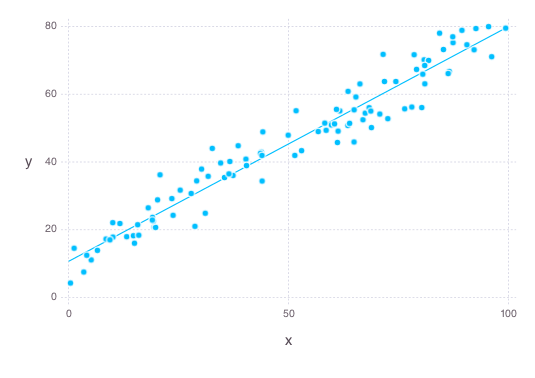

In [16]:
# 結果プロット
θ1 = ret.sol

x_linspace = linspace(0,100)
f(x) = θ1[1] .+ x .* θ1[2]
plot(layer(x=x, y=y, Geom.point), layer(x=x_linspace, y=f(x_linspace), Geom.line))

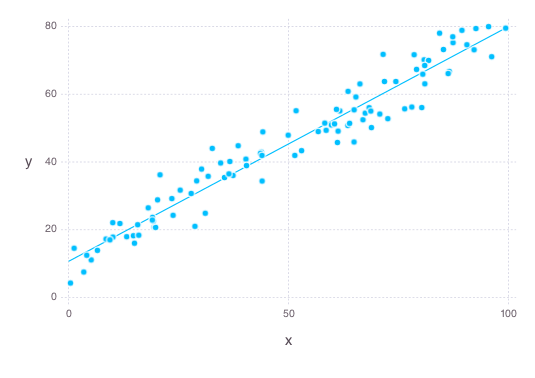

In [17]:
# 例1-2: llsq で求解
θ2 = llsq(X, y)

x_linspace = linspace(0,100)
f(x) = θ2[1] .+ x .* θ2[2]
plot(layer(x=x, y=y, Geom.point), layer(x=x_linspace, y=f(x_linspace), Geom.line))

### 例2：Clustering.jl で K-means

本日のハンズオンで利用したサンプルデータを利用。

In [18]:
# パッケージ読込
# Pkg.add("Clustering")
using Clustering

In [19]:
# 学習（data は先ほど読み込んだデータ）
X = data
K = 3

model = kmeans(X', K; maxiter=10, display=:iter)

Clustering.KmeansResult{Float64}(2x3 Array{Float64,2}:
  3.91875  14.21    10.1009 
 11.1456   13.9303   2.90441,[3,1,2,3,3,1,3,3,1,2  …  3,1,3,3,2,1,1,3,2,1],[8.57266,6.92678,7.7371,13.2633,0.0355967,5.11937,5.06906,3.04261,2.91053,8.28019  …  0.765279,1.4695,0.88455,9.90113,7.78251,2.4756,1.9285,3.75704,14.6554,15.5151],[32,30,34],[32.0,30.0,34.0],545.1195459313719,2,true)

Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       6.472333e+02
      1       5.451195e+02      -1.021138e+02 |        0
      2       5.451195e+02       0.000000e+00 |        0
K-means converged with 2 iterations (objv = 545.1195459313719)


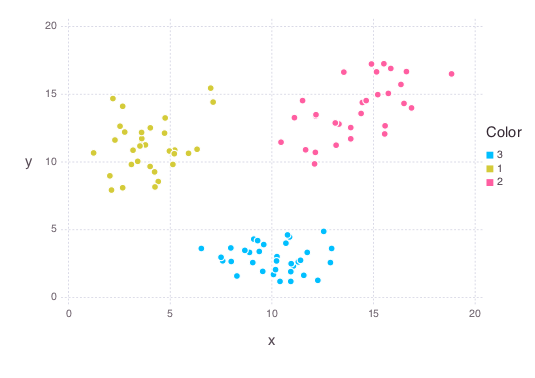

In [20]:
# 結果確認（dispResult 関数は先ほど定義したもの（Clustering パッケージには含まれません））
dispResult(X, model.assignments)

## 参考

+ [The Julia Language](http://julialang.org/)（本家サイト、英語）
+ [X分で学ぶJulia - りんごがでている](http://bicycle1885.hatenablog.com/entry/2014/12/01/050522)（日本語の分かりやすいチュートリアル記事）
+ [Julia - josephmisiti/awesome-machine-learning](https://github.com/josephmisiti/awesome-machine-learning#julia-general-purpose)（Julia の機械学習関連ライブラリのリンクまとめ。英語）

ご清聴ありがとうございます。